<a href="https://www.kaggle.com/code/simonlalonde/vol-o2-beers1668-1671-1672?scriptVersionId=98544394" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
pd.options.mode.chained_assignment = None  # default='warn'
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt



# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/vol-o2-3beers-1668-1671-1672/o2-vol-3beers-1668-1670-1671.csv
/kaggle/input/vol-o2-3beers-1668-1671-1672/o2-vol-3beers-1668-1670-1671_full.csv


# Exploration of relationship between dissolved oxygen (DO or O2) readings and packaged beer volume using test dataset of 3 different lots of beers from a craft brewery in Québec. 
---------
## The beers :

- [Notre Folie](https://siboire.ca/fr/boutique/bieres/3968024-notre-folie-100-qc/)
- [IPA Test #96](https://untappd.com/b/siboire-microbrasserie-ipa-test-96-citra-spectrum-citra-lupomax-citra/4847087)
- [Inspiration](https://siboire.ca/fr/boutique/bieres/213673-inspiration/)

## The measurements :
1. Weight of packaged beer : 
    Lab balance with 0.01 g readability
2. 3-minutes shaken CO2 and O2 readings of packaged using CBoxQC (Anton Paar; [CboxQC](https://www.anton-paar.com/us-en/products/details/cboxqc/)) and c-DGM (Haffmans; [c-DGM](https://foodandbeverage.pentair.com/en/products/haffmans-portable-optical-co2-o2-tpo-meter-c-dgm))

---

## Useful data and formulas :
- Empty can weight (hard print) = 15.8 g
- density p = mass (g) / volume (mL)
- Plato to SG conversion with ASBC's online conversion tools : 
[Extract to Specific Gravity](https://www.asbcnet.org/Methods/Tools/extras/Documents/Extract_to_Specific_Gravity.pdf)
- Water density at 20C from Handbook of Chemistry : [H20_20C_g/mL](https://collett.atmos.colostate.edu/classes/AT560/2007/water-density.pdf)

--- 

## Question
<code style="background:yellow;color:black">**Is there relationship between dissolved O2 levels and volume of beer in final package? Could we predict O2 levels from volume of beer in package?**</code>
***

# Import raw data and cleanup
***
Import data as df using the Pandas lib


In [2]:
# Import raw data + check sample pop and NAs
rawDf = pd.read_csv("../input/vol-o2-3beers-1668-1671-1672/o2-vol-3beers-1668-1670-1671_full.csv", sep=";", decimal=",")
rawDf.head(10)


,Beer,Lot,Density (Plato),weight (g),O2 (ppb),CO2 (vol/vol)
0,NF,1670,2.48,498.5,347.0,2.62
1,NF,1670,2.48,495.7,231.0,2.60
2,NF,1670,2.48,485.9,274.0,2.52
3,NF,1670,2.48,468.5,409.0,2.52
4,NF,1670,2.48,NaN,103.0,2.63
5,NF,1670,2.48,496.7,241.0,2.60
6,NF,1670,2.48,498.0,62.7,2.57
7,NF,1670,2.48,496.8,219.0,2.58
8,IPAT96,1668,3.40,NaN,91.0,2.63
9,IPAT96,1668,3.40,NaN,99.0,2.63


In [3]:
# Looking for NAs
rawDf.count()
# Dropping NAs we have n=28 samples left

Beer               34
Lot                34
Density (Plato)    34
weight (g)         28
O2 (ppb)           33
CO2 (vol/vol)      33
dtype: int64

In [4]:
# change weight column name + remove NAs
rawDf = rawDf.rename(columns={"weight (g)": "full weight (g)"})
df = rawDf.dropna()


In [5]:
# Check if dtypes OK
df.dtypes


Beer                object
Lot                  int64
Density (Plato)    float64
full weight (g)    float64
O2 (ppb)           float64
CO2 (vol/vol)      float64
dtype: object

# Calculate the volume of beer in package
***
## Strategy :
1. Determine weight of liquid beer in can
2. Calculate specific gravity (SG)
3. Calculate the volume of beer in can (mL)


In [6]:
# Determine weight of beer liquid only
# Regular hard printed can body + lid weight = 15.8 g
# NO USER INPUT emptyCan = float(input("Enter weight of empty can + lid :"))
emptyCan = 15.8
df["liquid weight (g)"] = df["full weight (g)"] - emptyCan

# Convert Plato density to specific gravity (SG)
df["SG"] = df["Density (Plato)"] / (258.6-((df["Density (Plato)"]/258.2)*227.1))+1

# Calculate beer liquid volume in package (mL)
watDens20C = 0.998207
df["beer volume (mL)"] = df["liquid weight (g)"] / (df["SG"]*watDens20C)
df.head()

,Beer,Lot,Density (Plato),full weight (g),O2 (ppb),CO2 (vol/vol),liquid weight (g),SG,beer volume (mL)
0,NF,1670,2.48,498.5,347.0,2.62,482.7,1.009672,478.93493
1,NF,1670,2.48,495.7,231.0,2.60,479.9,1.009672,476.15677
2,NF,1670,2.48,485.9,274.0,2.52,470.1,1.009672,466.43321
3,NF,1670,2.48,468.5,409.0,2.52,452.7,1.009672,449.16893
5,NF,1670,2.48,496.7,241.0,2.60,480.9,1.009672,477.14897


# Exploratory data analysis
***
## Data visualization for further cleaning
- Check distributions for beer volume, CO2 and O2
- Remove outliers

<AxesSubplot:xlabel='beer volume (mL)', ylabel='Count'>

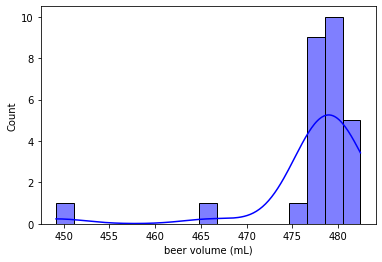

In [7]:
# Beer volume histogram all beers
sns.histplot(data=df, x="beer volume (mL)", color="blue", kde=True)



<AxesSubplot:xlabel='beer volume (mL)', ylabel='Count'>

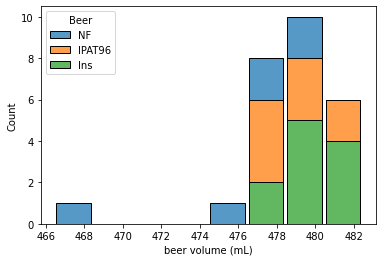

In [8]:
# Remove outliers z-score > 3 for "beer volume (mL)"
df = df[(np.abs(stats.zscore(df["beer volume (mL)"])) < 3)]
sns.histplot(data=df, x="beer volume (mL)",hue="Beer", shrink=0.9, multiple="stack")

<AxesSubplot:xlabel='O2 (ppb)', ylabel='Count'>

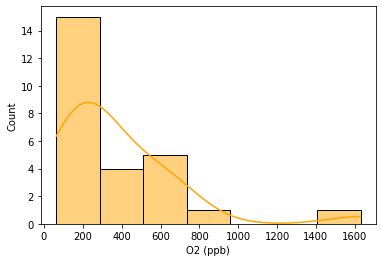

In [9]:
# O2 histogram
sns.histplot(data=df, x="O2 (ppb)", kde=True, color="orange")

<AxesSubplot:xlabel='O2 (ppb)', ylabel='Count'>

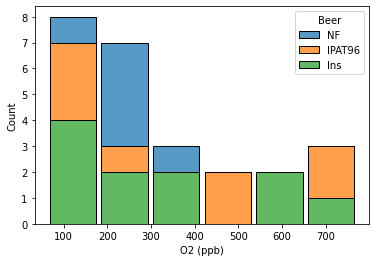

In [10]:
# Remove outliers z-score > 3 for "O2 (ppb)" 
df = df[(np.abs(stats.zscore(df["O2 (ppb)"])) < 3)]
sns.histplot(data=df, x="O2 (ppb)",hue="Beer", shrink=0.9, multiple="stack")

<AxesSubplot:xlabel='CO2 (vol/vol)', ylabel='Count'>

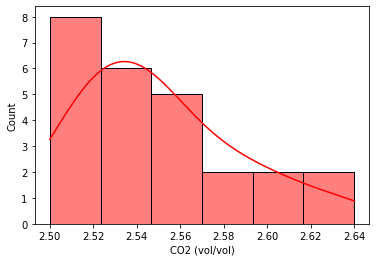

In [11]:
# CO2 histo
sns.histplot(data=df, x="CO2 (vol/vol)", kde=True, color="red")

## Evaluating the relationship between volume of beer in package and dissolved oxygen levels
***
Pearson correlation method

<AxesSubplot:xlabel='beer volume (mL)', ylabel='O2 (ppb)'>

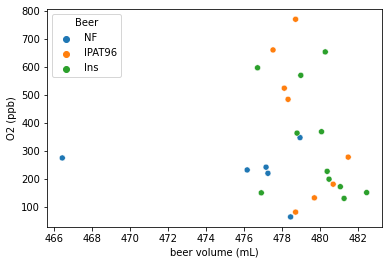

In [12]:
# Scatterplot for volume vs. O2
sns.scatterplot(data=df, x="beer volume (mL)", y="O2 (ppb)", hue="Beer")


<AxesSubplot:xlabel='beer volume (mL)', ylabel='O2 (ppb)'>

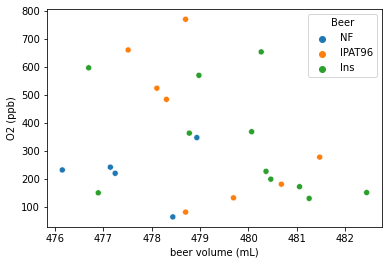

In [13]:
# Drop outlier and replot scatterplot
df = df.drop(index=2)
sns.scatterplot(data=df, x="beer volume (mL)", y="O2 (ppb)", hue="Beer")

<AxesSubplot:xlabel='beer volume (mL)', ylabel='O2 (ppb)'>

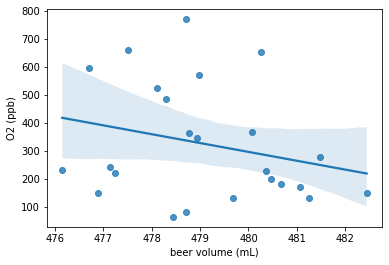

In [14]:
# Linear regression seems to indicate there is a slight tendency for inverse correlation
sns.regplot(data=df, x="beer volume (mL)", y="O2 (ppb)")

<AxesSubplot:>

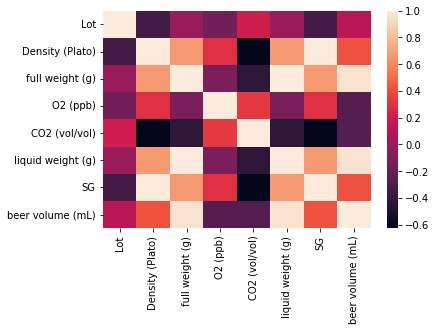

In [15]:
# Pearson correlation for all features

correlations = df.corr(method="pearson")
cmap = sns.diverging_palette(220, 20, as_cmap=True)
sns.heatmap(data=correlations)


<AxesSubplot:>

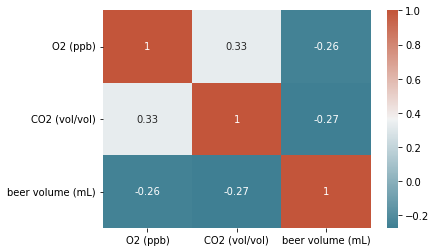

In [16]:
# Filtering for features of interest

corrInt = correlations[["O2 (ppb)", "CO2 (vol/vol)","beer volume (mL)"]]
corrInt = corrInt.drop(["Lot", "Density (Plato)", "full weight (g)", "liquid weight (g)", "SG"])
cmap = sns.diverging_palette(220, 20, as_cmap=True)
sns.heatmap(data=corrInt, cmap=cmap, annot=True)

In [17]:
# Print exact pearson correlation coefficient
r = correlations.loc["O2 (ppb)", "beer volume (mL)"]
print("r for O2 vs volume:", "%.4f" % r)

r for O2 vs volume: -0.2581


# Conclusion from Pearson correlation
***

beer volume (mL)|-0.26|
---|---|
.|**O2 (ppb)**|

<span style="background-color: #FFFF00">With this small dataset, there is not a very strong negative correlation between dissolved oxygen levels and the volume of beer in package. **Therefore, we could theoretize that package beer levels is not a good predictor of O2 levels. However, we would need to inrease sample size and look at other variables such as foam amount and thickness, carbonatation and temperature.**</span>
